# Geolocalización

In [27]:
import os
import time
import requests
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Los _tweets_ tienen la ubicación. Para construir un mapa necesitamos convertir la ubicación en coordenadas geográficas. Para ello podemos utilizar el API de _Google maps_ o _OpenStreetMap_.

Para usar el api de _Google maps_ necesitaremos un `api_key`: [Get an API Key](https://developers.google.com/maps/documentation/javascript/get-api-key)

In [2]:
api_key = ""

In [3]:
def get_geolocation(location):
    global api_key
    url = "https://maps.googleapis.com/maps/api/geocode/json?address={}&sensor=false&key={}".format(location, api_key)
    response = requests.get(url)
    results = json.loads(response.text)['results']
    if results:
        return results[0]['geometry']['location']

In [4]:
get_geolocation('Palma de Mallorca')

{'lat': 39.5696005, 'lng': 2.6501603}

In [5]:
get_geolocation('Illes Balears')

{'lat': 39.3587759, 'lng': 2.7356328}

In [6]:
get_geolocation('Marratxí')

{'lat': 39.627193, 'lng': 2.7572077}

Vamos a probar con algunos _tweets_

In [7]:
tweets_es = pd.read_feather('../data/tweets_es')
tweets_es['tw_ubicacion']

0                       Zárate Bs As
1                   Andalucía-Murcia
2          Desde Chile para el Mundo
3                            Ecuador
4                                   
                    ...             
25360             Caracas, Venezuela
25361    Madrid, Comunidad de Madrid
25362        Viladecans  (Barcelona)
25363                        Hamburg
25364        Guadalajara Jal. Mexico
Name: tw_ubicacion, Length: 25365, dtype: object

In [8]:
%%time
get_geolocation('Andalucía-Murcia')

CPU times: user 18 ms, sys: 1.48 ms, total: 19.5 ms
Wall time: 682 ms


{'lat': 37.9847332, 'lng': -1.1329876}

In [9]:
get_geolocation('Zárate Bs As')

{'lat': -34.0957811, 'lng': -59.0242302}

In [10]:
%%time
geolocation = [get_geolocation(loc) for loc in tweets_es['tw_ubicacion'][:300] if loc]

CPU times: user 7.48 s, sys: 432 ms, total: 7.91 s
Wall time: 1min 56s


In [11]:
len(geolocation)

213

**Geocoding**

[Geocode with Python](https://towardsdatascience.com/geocode-with-python-161ec1e62b89)

In [12]:
#!pip install geopandas
#!pip install geopy

In [13]:
from geopy.geocoders import Nominatim

In [14]:
%%time
locator = Nominatim(user_agent="myGeocoder")
location = locator.geocode('Palma de Mallorca')

CPU times: user 32.7 ms, sys: 959 µs, total: 33.7 ms
Wall time: 247 ms


In [15]:
print("Latitude = {}, Longitude = {}".format(location.latitude, location.longitude))

Latitude = 39.5695818, Longitude = 2.6500745


In [16]:
from geopy.extra.rate_limiter import RateLimiter

In [17]:
tweets_limpios = pd.read_feather('../data/tweets_limpios')
tweets_limpios.head()

,text,index
0,promotoresods desear feliz año necesitar esper...,6
1,aplicación regar aguar depurar enzima natural ...,7
2,lunes estrenar esperar 19:30 _ 13c viajar para...,8
3,década cumplir objetivo agenda2030 preparar en...,9
4,nº 329 homenaje municipalismo 40añosdedemocrac...,10


In [18]:
df = pd.DataFrame(tweets_es['tw_ubicacion'])
df.head()

,tw_ubicacion
0,Zárate Bs As
1,Andalucía-Murcia
2,Desde Chile para el Mundo
3,Ecuador
4,


In [19]:
from geopy.geocoders import GoogleV3

#locator = Nominatim(user_agent="myGeocoder")
locator = GoogleV3(api_key = api_key)

Creamos una copia del dataframe `tweets_es` al que añadiremos las coordenadas geográficas.

In [20]:
df = pd.DataFrame(tweets_es['index'])
ubicacion = np.where(tweets_es['tw_ubicacion_orig'], tweets_es['tw_ubicacion_orig'], tweets_es['tw_ubicacion'])
df['ubicacion'] = ubicacion
df.head()

,index,ubicacion
0,6,Zárate Bs As
1,7,Andalucía-Murcia
2,8,Chile
3,9,Ecuador
4,10,Madrid


El uso gratuito de las APIs tiene limitaciones. Sobre todo en la frecuencia en la que se pueden hacer llamadas. Para evitar que nos bloqueen limitamos las llamadas a 1 por segundo. Como hay unos 25000 _tweets_, obtener todas las coordenadas tardará unas **7 horas**.

In [21]:
%%time
%%capture

if os.path.exists('../data/geolocation'):
    df = pd.read_feather('../data/geolocation')
else:
    geocode = RateLimiter(locator.geocode, min_delay_seconds=1, max_retries=0)
    df['location'] = df['ubicacion'].apply(geocode)
    df['point'] = df['location'].apply(lambda loc: tuple(loc.point) if loc else None)
    df[['latitude', 'longitude', 'altitude']] = pd.DataFrame(df['point'].tolist(), index=df.index)
    df[['index','latitude','longitude']].to_feather('../data/geolocation')

CPU times: user 9.14 ms, sys: 1.02 ms, total: 10.2 ms
Wall time: 8.59 ms


In [22]:
df.head(10)

,index,latitude,longitude
0,6,-34.095781,-59.024230
1,7,37.984733,-1.132988
2,8,-35.675147,-71.542969
3,9,-1.831239,-78.183406
4,10,40.416775,-3.703790
5,11,40.416775,-3.703790
6,14,37.389092,-5.984459
7,15,41.902783,12.496365
8,17,23.634501,-102.552784
9,20,NaN,NaN


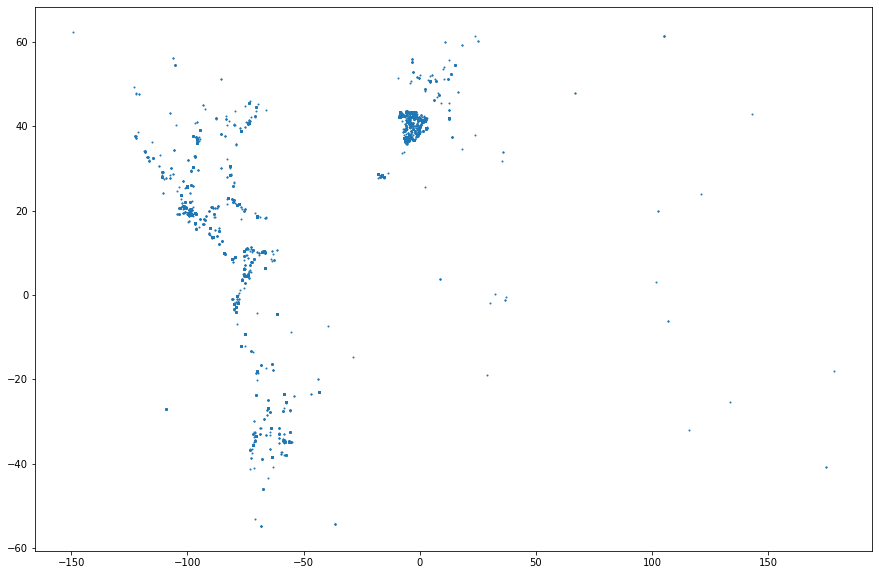

In [23]:
fig = plt.figure(figsize=(15,10))
plt.scatter(df['longitude'], df['latitude'], s=1);

Vamos a añadir la información de los ods.

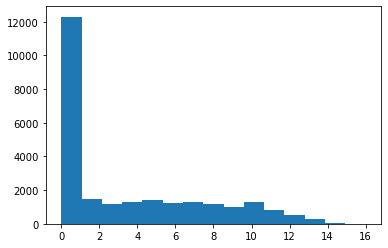

In [24]:
tweets_ods = pd.read_feather('../data/tweets_ods')
tweets_ods_freq = tweets_ods.iloc[:, 2:].apply(sum, axis=1)
plt.hist(tweets_ods_freq, bins=15);

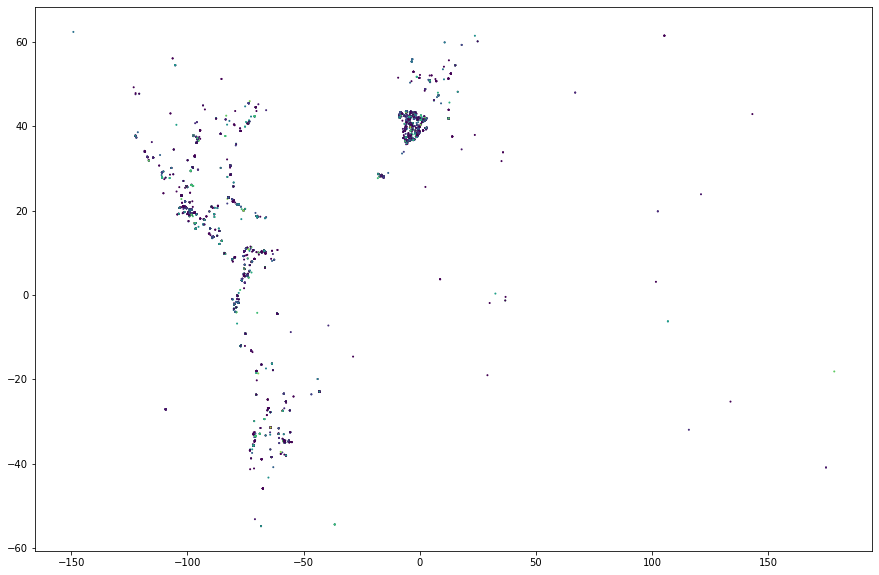

In [25]:
fig = plt.figure(figsize=(15,10))
plt.scatter(df['longitude'], df['latitude'], s=1, c=tweets_ods_freq);

Algo más colorido

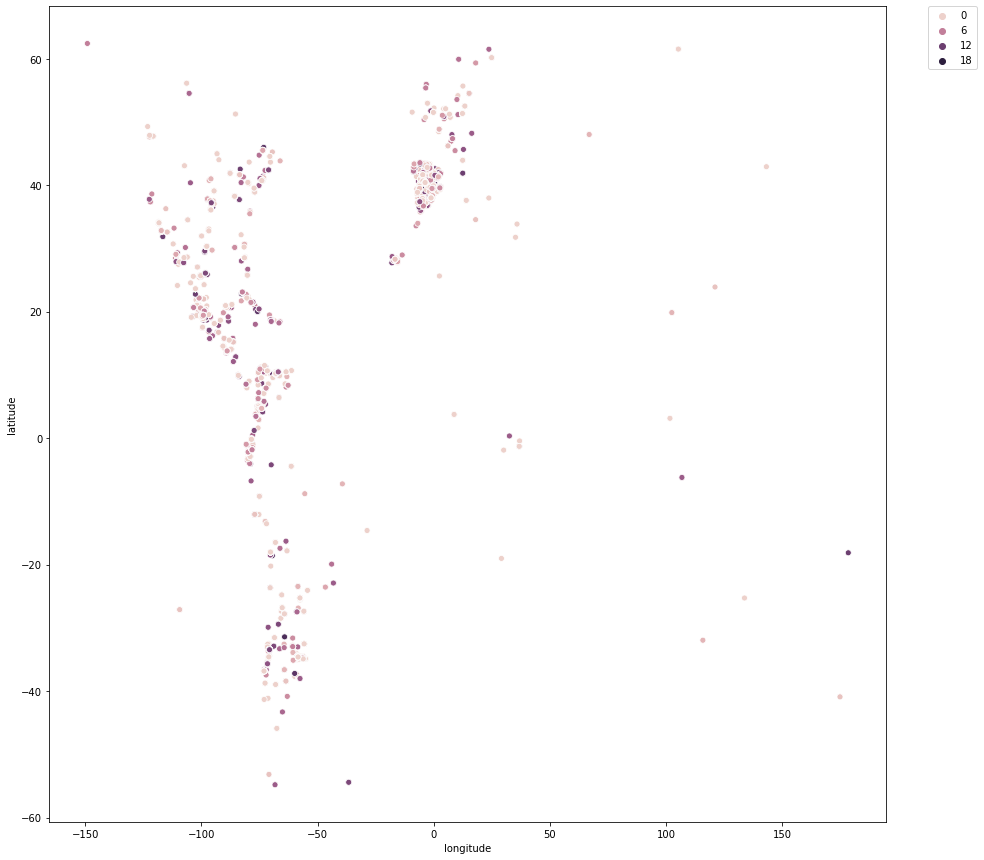

In [28]:
plt.figure(figsize=(15, 15))
sns.scatterplot(y='latitude',
                x='longitude',
                data=df,
                hue=tweets_ods_freq)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

Dejamos pendiente sacar el gráfico con un mapa de fondo y con proporciones correctas.